<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/week07_part1_VAE_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders

![](http://kvfrans.com/content/images/2016/08/vae.jpg)
Image taken from [here](http://kvfrans.com/variational-autoencoders-explained/)

In last week's tutorial we presented how to learn a meaningful representation of the data by using an autoencoder. In the autoencoder, the input image was transformed into a vector which encoded the information from the image in a lower dimensionality space. Then, we decoded that vector to get a reconstruction of the input image. However, the model was focused on encoding existing data for representation learning or similar purposes. To tackle the generation of new data, we will use the Variational Autoencoder (VAE) approach. The image shows an overview of the VAE method.

Parts of the code are taken from [here](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/), which contains a more in-depth explanation. 


Before starting to define the different parts of the VAE, let's import the needed modules for this tutorial.

In [1]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda 
from keras.layers import Multiply, Add, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist, fashion_mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

from keras import initializers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

Using TensorFlow backend.


Now we load MNIST, which will be our toy dataset for this example.

In [2]:
original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.   

11501568/11490434 [==============================] - 1s 0us/step


Now let's do a quick recap of the Variational AutoEncoder (VAE) theory. As stated in the lecture slides, we want to find the $\hat{\theta}$ that approximates $P_\theta(x)$ by doing:

$$
\hat{\theta} = \text{argmin}_\theta \sum_{i=1}^n \mathbb{E}_{Q_\phi(z|x_i)}[\log(P_\theta(x_i|z))] - \text{KL}(Q_\phi(z|x_i) || P_\theta(z))
$$

We will train our model using a stochastic approach by sampling mini-batches from the dataset to minimize this measure. First, we define the two losses we will use. The loss `nll` is the first term of the equation, whereas the `KLDivergenceLayer` is the second term of the loss. The `KLDivergenceLayer`will be used to compute an extra loss in the middle of the model via the `self.add_loss` function, but it does not change its inputs.

In [0]:
def nll(y_true, y_pred):
  """ Negative log likelihood (Bernoulli). """

  # keras.losses.binary_crossentropy gives the mean
  # over the last axis. we require the sum
  return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

class KLDivergenceLayer(Layer):

  """ Identity transform layer that adds KL divergence
  to the final model loss.
  """

  def __init__(self, *args, **kwargs):
    self.is_placeholder = True
    super(KLDivergenceLayer, self).__init__(*args, **kwargs)

  def call(self, inputs):
    mu, log_var = inputs
    kl_batch = - .5 * K.sum(1 + log_var -
                            K.square(mu) -
                            K.exp(log_var), axis=-1)
    self.add_loss(K.mean(kl_batch), inputs=inputs)

    return inputs

In the last block, we just defined the two losses we will use. Here we build the whole VAE model. First, we build the encoder by using some Linear layers and ReLU activation functions. The goal of the encoder $\phi$ is to approximate $P_\theta(z|x_i)$ via $Q_\phi(z|x_i)$ as stated in the slides.  We assume that $P(z)$ is a Normal distribution with zero mean and unit variance. We also assume that $Q(z|x)={N}(\mu_x, \sigma_x)$ so the encoder tries to recover the parameters $\mu_x, \sigma_x$ for the different $x$ (which are the input images), i.e. the encoder outputs for each latent dimension a mean and standard deviation. The code for this encoder is the following:


In [4]:
## Encoder

intermediate_dim = 256
latent_dim = 2
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

Instructions for updating:
Colocations handled automatically by placer.


As we mentioned, the encoder will output the parameters $\mu_x, \sigma_x$. Now we will sample from the normal distribution defined by those parameters to pass it to the decoder. However, we now face one of the problems of implementing a VAE: we want to optimize both decoder and encoder at the same time to i) encourage good reconstruction and ii) to make $z$ follow a normal distribution. What is the problem here? Using a standard sampling method, i.e by directly sampling using the mean and standard deviation output by the encoder, we cannot train it in an end-to-end manner as sampling is not a differentiable operation. 

We need a trick to solve this issue. We can use one of the properties of the Normal probability distribution, which is that sampling $\mathcal{N}(\mu_\psi, \sigma_\psi)$ is the same as $\mu_\psi + \sigma_\psi\mathcal{N}(0, 1)$. Now, the sampling process is just a factor multiplying by the prediction $\sigma_\phi$ of the encoder, meaning we can propagate the gradients from the output back to the encoder. This is called the reparametrisation trick. We use this trick in the following block.

In [0]:
##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

Now we define the decoder, which will take the sampling from $\mathcal{N}(\mu_\psi, \sigma_\psi)$ as input and output an image. We just use a couple of Linear layers with some activation functions to do so.

In [0]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])
  
x_pred = decoder(z)

We have defined both the encoder and the decoder, and we are ready to train the model. We now build the model, which will have two inputs: the image `x`  for the encoder; and the sample `eps` (which refers to the sample from $\mathcal{N}(0, 1)$ we mentioned before) for the decoder, which will use $\mu_x, \sigma_x$ via the reparametrisation trick.

In [0]:
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

Now we train the model for some epochs to see if we can model our data. After the training process we will use this trained VAE to generate new data. 

In [8]:
epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 172us/step - loss: 180.7926 - val_loss: 168.5937
Epoch 2/20
60000/60000 [==============================] - 7s 125us/step - loss: 166.6318 - val_loss: 165.0240
Epoch 3/20
60000/60000 [==============================] - 8s 127us/step - loss: 163.5344 - val_loss: 162.7833
Epoch 4/20
60000/60000 [==============================] - 8s 127us/step - loss: 161.2365 - val_loss: 160.5179
Epoch 5/20
60000/60000 [==============================] - 8s 126us/step - loss: 159.5196 - val_loss: 158.8632
Epoch 6/20
60000/60000 [==============================] - 8s 126us/step - loss: 158.3352 - val_loss: 157.9796
Epoch 7/20
60000/60000 [==============================] - 8s 125us/step - loss: 157.3968 - val_loss: 157.9273
Epoch 8/20
60000/60000 [==============================] - 7s 125us/step - loss: 156.6631 - val_loss: 156.5619
Epoch 9/20
60000/6000

We trained an encoder to model $Q(z|x)$ which outputs two parameters per latent dimension for each image $x$, which are  $\mu_x, \sigma_x$. We now plot the distribution of the $\mu_x$ when encoding the different images from the test set.

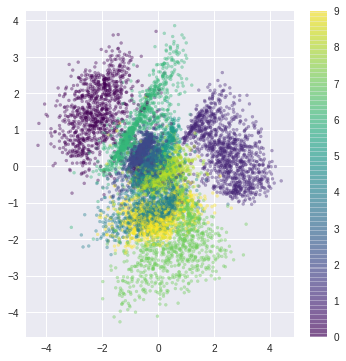

In [9]:
encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

The distribution of the encoded means shows how they are clustered by class too, as in the autoencoder case. However, in this case, the distribution also follows a kind of circular distribution around the centre due to the Kullback Leibler divergence term in the loss. We made the $\mu_x$ output by the encoder to be close to zero, and $\sigma_x$ to be close to 1. 

Now let's start with the generation of data, which is the main reason we trained this model. 

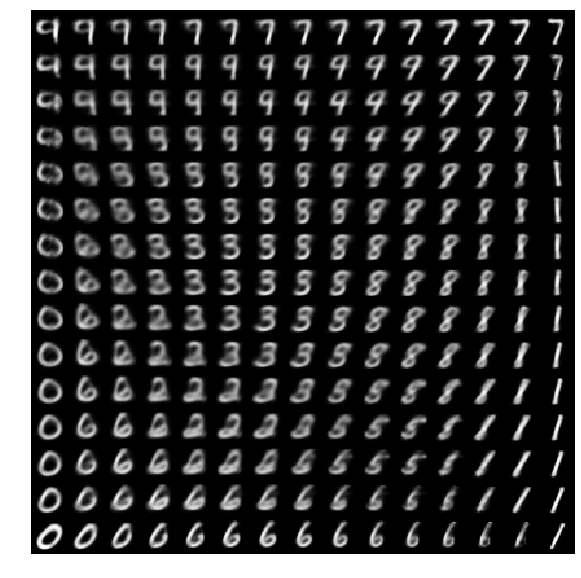

In [10]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

You can see in the image how there is a smooth transition between the different generated numbers.

Now let's generate a nice animation for the latent variable, where we show the point we used in $z$ to generate the data and the corresponding image generated.

In [0]:
## We create a 2d array
# Number of points to use, increase it for smoother animation
# Using more points makes the function slower
n_points = 50
# theta from 0 to 2pi
theta = np.linspace(0, 2*np.pi, n_points)
# radius of the circle (vary it depending on your reprentation space plot)
r = 1
# compute x and y (you can add an offset depending on your latent space)
offset_x = 0
offset_y = 0
x = r*np.cos(theta) + offset_x
y = r*np.sin(theta) + offset_y
latent = np.stack([x, y], -1)

## We now plot as before the 2d scatter with the images from the test set 
## and the corresponding label
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(1,2)
ax = fig.add_subplot(121)
ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')

## This is needed to print the circle point (black point in the animation)
scat = ax.scatter(latent[0,0], latent[0,1], s=200, c='k')

## Create second plot with the generated image
fig.add_subplot(122)
latent_im = decoder.predict(latent)
im = plt.imshow(latent_im[0].reshape(28, 28), animated=True, cmap='gray')
def updatefig(i):
    global latent_im
    global latent, scat
    scat.set_offsets(latent[i])
    im.set_array(latent_im[i].reshape(28, 28))
    return im,
from matplotlib import animation
anim = animation.FuncAnimation(fig, updatefig, interval=200, save_count=latent.shape[0])
from IPython.display import HTML
HTML(anim.to_html5_video())
plt.close()


# Generative Adversarial Networks



![](https://skymind.ai/images/wiki/GANs.png)
[Image taken from here](https://skymind.ai/wiki/generative-adversarial-network-gan)

Generative Adversarial Networks have been shown to improve the generation of data compared to approaches such as VAE.

As you learnt in the lecture, we have two networks playing what is called a min max game between them. The Generator, $G$, tries to generate data that looks similar to real data, whereas the discriminator $D$ tries to distinguish between real and fake data.

Code adapted from [here](https://oshearesearch.com/index.php/2016/07/01/mnist-generative-adversarial-model-in-keras/).


We first define $G$ here, and in this case we will use a convolutional network. Notice that we use what is called LeakyReLU for the activation functions, which have been shown to work well when using GANs. $G$ will take a vector of noise (in this case of dimensionality 10) sampled from $\mathcal{N}(0, 1)$ and output a generated image. We use `tanh` as the last activation because the data will be normalized to be between $[-1, 1]$.

In [12]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 10
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
__________

Here, we define the discriminator $D$. The discriminator is trained with the `categorical_crossentropy` loss, but you could also use a binary loss, as its job is to discriminate between real and fake data.

In [13]:
# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
___________________________

We defined the combined network, which combines the generator and discriminator in a network. The discriminator, however, will not be updated when using this combined network. We will explain later why, but basically we will use the `discriminator` object (not the combined network) whenever we need to update the discriminator.

In [14]:
# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


Now, let's define some helper functions that will be used to plot the loss and some generated images during training.

In [0]:
def plot_loss(losses):
    plt.figure()
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.savefig('./loss.png')
    plt.close()
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.normal(0,1,size=[n_ex,randomDim])
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./images.png')
    plt.close()

We will not use the regular fit method to train the model as in the usual approach. The reason for this is that the min max game that the GANs do, in practice is implemented in each of the batches by using two different training steps.
* **First step - Training the discriminator: ** In this step only the discriminator is trained.  The generator will output some fake images using noise as input. Then, we will give the discriminator these generated images and some images sampled from the real dataset and train it to distinguish between the two of them. 

* **Second step - Updating the generator**: We use the generator to output fake images again, and the discriminator will try to guess if these newly generated images are real or fake. However, the aim in this second step is not to update the discriminator, only the generator. This is why in the combined network we made the discriminator not to be trainable. The discriminator is used to pass information (in the form of gradients in this case) to update the generator. Hence, the generator will try to change its weights to make the discriminator think the data comes from the real distribution.

In [0]:
def train_epoch(gan, generator, discriminator, plt_frq=25,BATCH_SIZE=32):  
  vector_ind = np.random.permutation(x_train.shape[0])
  nb_epoch = int(x_train.shape[0]/BATCH_SIZE)
  pbar = tqdm_notebook(range(nb_epoch))
  for e in range(nb_epoch):  
    ind = vector_ind[e*BATCH_SIZE:(e+1)*BATCH_SIZE]
    # Make generative images
    image_batch = x_train[ind,:,:,:]    
    noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    generated_images = generator.predict(noise_gen)

    # Train discriminator on generated images
    X = np.concatenate((image_batch, generated_images))
    y = np.zeros([2*BATCH_SIZE])
    y[0:BATCH_SIZE] = 1
    y[BATCH_SIZE:] = 0

    #make_trainable(discriminator,True)
    d_loss  = discriminator.train_on_batch(X,y)
    losses["d"].append(d_loss)
    # train Generator-Discriminator stack on input noise to non-generated output class
    noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    y2 = np.zeros([BATCH_SIZE])
    y2[:] = 1

    #make_trainable(discriminator,False)
    g_loss = gan.train_on_batch(noise_tr, y2 )
    losses["g"].append(g_loss)

    # Updates plots. This is a little bit of a mess due to how the notebook
    # handles the outputs
    if e % plt_frq==plt_frq-1:
      plot_loss(losses)
      plot_gen()
      fig, ax = plt.subplots(2,1, figsize=(20,10) )
      img=mpimg.imread('loss.png')
      ax[0].imshow(img)
      ax[0].axis('off')
      img=mpimg.imread('images.png')
      ax[1].imshow(img)
      ax[1].axis('off')
      plt.tight_layout()
      display.clear_output(wait=True)
      pbar.update(plt_frq)
      display.display(pbar)
      display.display(fig)
      plt.close()


Let's start the training process. We will use MNIST again. A standard practice for GANs is to normalize images to so the values are between $[-1, 1]$, so we apply that normalization. We train it for 10 epochs.

1800/|/ 96%|| 1800/1875 [00:59<00:02, 30.18it/s]

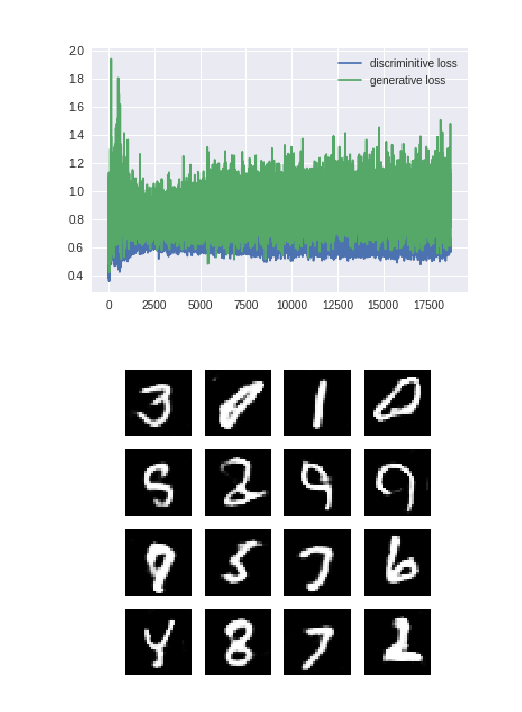

In [17]:
# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
# print(x_train[0])
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

The plots show how the training loss for both the generator and the discriminator does not change much. Usually we have a model which we optimize to reduce some metric/loss we pass it. However, in this case we have two models which are 'competing' against each other, so their losses are approximately stable. Now let's plot some results, as in the VAE case, we plot the results when sampling from 2 of the dimensions of the input noise $z$. However, as in this case we used more than 2 dimensions for $z$, the results vary due to choosing at random the 2 dimensions where to sample from.

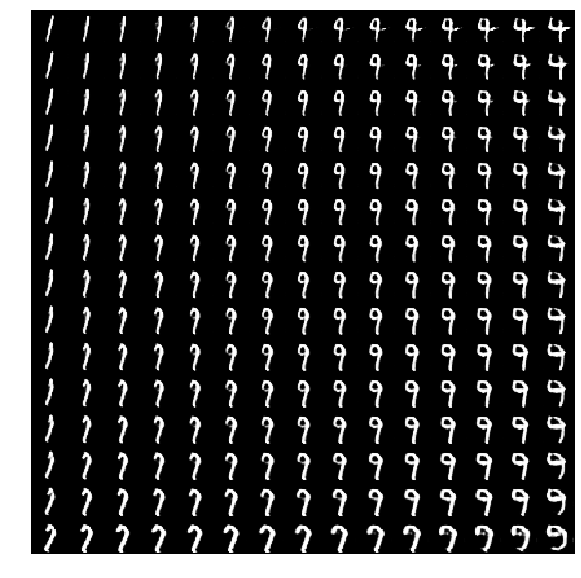

In [18]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

## Training instability
GANs are quite difficult to train as there are several factors that can hurt their performance. Some of the most frequent issues are: 

* [Mode collapsing](https://www.youtube.com/watch?v=ktxhiKhWoEE): The generator is not capable of creating diverse images, it only generates a limited set of images.
* Discriminator loss decreases quickly: in some cases the discriminator may be too powerful, so it quickly learns at the beginning which images are fake and which real, leading to small gradients passed to the generator.
* Hyper parameter sensitivity
* Non-convergence

There are some tricks that have been shown to improve convergence, some of them are shared in this [repo](https://github.com/soumith/ganhacks).

